### Setup

In [1]:
import os
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random

# Specify the path to the main directory, this is the segment-anything-2 path
main_directory = "/home/asdasd/segment-anything-2"

# Change the current working directory to the main directory
os.chdir(main_directory)

In [2]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


#### Utility functions to show results using OpenCV

In [3]:
from utility_functions import resize_yolo_masks_tensor, draw_yolo_mask, draw_sam2_mask, draw_masks_on_image, draw_points, draw_boxes

#### Utility functions to show results using Matplotlib

In [4]:
from utility_functions import show_mask, show_points, show_box, show_masks

#### Utility functions to get data from YOLO results

In [5]:
from utility_functions import get_bboxes, get_contours, find_centroid, get_centroids, find_point_inside_contour, get_points_inside_contours, generate_random_points_outside_boxes

#### Load YOLO and SAM2 models

In [6]:
from ultralytics import YOLO

yolo_checkpoint = "/home/asdasd/yolo-sam-2/yolo_weights/Salmons_YOLOv8.pt"
yolo_segmentator = YOLO(model=yolo_checkpoint, task="segment")

In [7]:
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

sam2_checkpoint = "checkpoints/sam2_hiera_large.pt"
model_cfg = "sam2_hiera_l.yaml"

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda")

predictor = SAM2ImagePredictor(sam2_model)

#### Load images from video
Frames are stored in a list of paths for each video frame, each frame is stored as a JPEG. This is not necesary when using the SAM2ImagePredictor class but is necesary for the SAM2VideoPredictor, so the code is shown here.

In [8]:
# `video_dir` a directory of JPEG frames with filenames like `<frame_index>.jpg`
video_dir = "/home/asdasd/yolo-sam-2/videos/SHORT_azul"

# scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))
frame_paths = [os.path.join(video_dir, frame_name) for frame_name in frame_names]

#### Load a image

In [9]:
# Load the image using OpenCV
image = cv2.imread(frame_paths[60])

# Convert the image to RGB (OpenCV loads images in BGR by default)
image_RGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#### Show with matplotlib

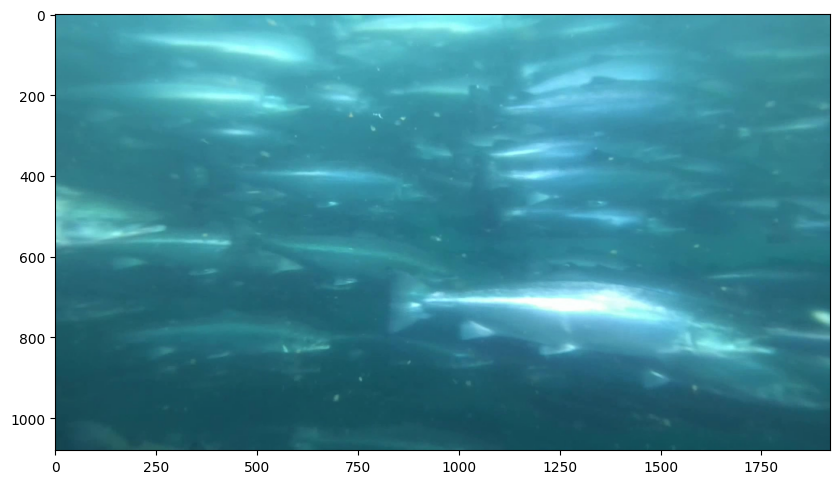

In [10]:
plt.figure(figsize=(10, 10))
plt.imshow(image_RGB)
plt.axis('on')
plt.show()

#### Display the image using OpenCV

In [11]:
#cv2.imshow('Truck Image', cv2.resize(image, (image.shape[1] // 2, image.shape[0] // 2)))
#cv2.waitKey(0)
#cv2.destroyAllWindows()

### Example 1: Use YOLO bbox as prompt

#### Obtain image bounding box using a YOLO detection


0: 384x640 12 salmons, 72.4ms
Speed: 2.7ms preprocess, 72.4ms inference, 108.6ms postprocess per image at shape (1, 3, 384, 640)


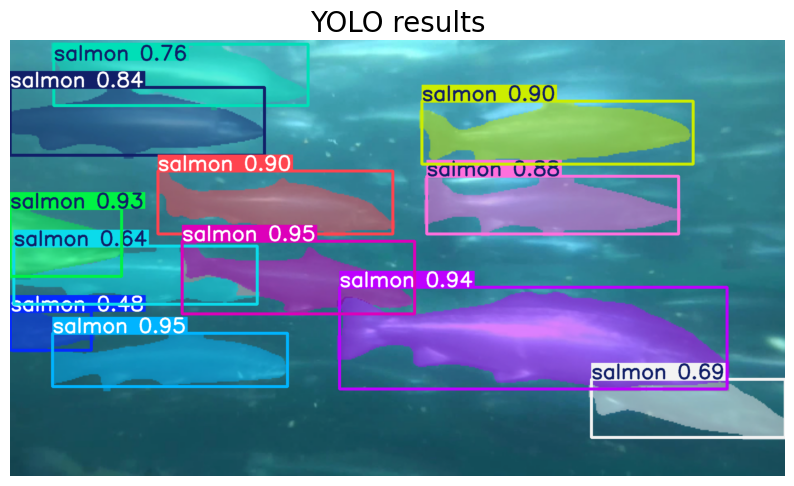

In [12]:
# Do a prediction with YOLO
results = yolo_segmentator.predict(image)
# Get the bboxes with YOLO
input_boxes = get_bboxes(results)[0]
# Set the SAM2 predictor to the image
predictor.set_image(image_RGB)

yolo_plot = cv2.cvtColor(results[0].plot(color_mode='instance'), cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 10))
plt.imshow(yolo_plot)
plt.axis('off')
plt.title("YOLO results", fontsize=20)
plt.show()

#### Do inference with SAM2 using boxes as prompt

In [13]:
masks, scores, logits = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_boxes,
    multimask_output=False
)
masks.shape # (number of masks, batches (multimask_output), H, W)

(12, 1, 1080, 1920)

In [14]:
masks

array([[[[          0,           0,           0, ...,           0,           0,           0],
         [          0,           0,           0, ...,           0,           0,           0],
         [          0,           0,           0, ...,           0,           0,           0],
         ...,
         [          0,           0,           0, ...,           0,           0,           0],
         [          0,           0,           0, ...,           0,           0,           0],
         [          0,           0,           0, ...,           0,           0,           0]]],


       [[[          0,           0,           0, ...,           0,           0,           0],
         [          0,           0,           0, ...,           0,           0,           0],
         [          0,           0,           0, ...,           0,           0,           0],
         ...,
         [          0,           0,           0, ...,           0,           0,           0],
         [          0,      

#### Show results with matplotlib

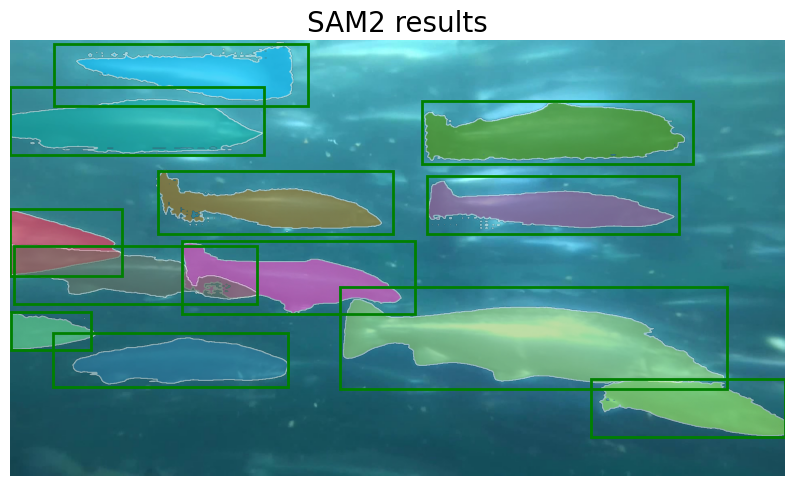

In [15]:
plt.figure(figsize=(10, 10))
plt.imshow(image_RGB)
for mask in masks:
    show_mask(mask.squeeze(0), plt.gca(), random_color=True)
for box in input_boxes:
    show_box(box, plt.gca())
plt.axis('off')
plt.title("SAM2 results", fontsize=20)
plt.show()

### Example 2: Using maks as input prompt

YOLO return it's masks as contours, so we need a way to convert them to masks.

In [16]:
def create_masks_from_contours_for_mask_input(original_shape, contours, target_size=(255, 255)):
    # Original dimensions
    original_height, original_width = original_shape[:2]
    
    # Initialize an array to hold all masks
    all_masks = np.zeros((len(contours), 1, *target_size), dtype=np.float32)
    
    for i, contour_points in enumerate(contours):
        # Convert contour points to integer type
        contour_points = contour_points.astype(np.int32)
        
        # Create a blank mask for the original dimensions
        mask = np.full((original_height, original_width), -20, dtype=np.float32)
        
        # Fill the contour on the mask with 10
        cv2.fillPoly(mask, [contour_points], 9)
        
        # Resize the mask to the target size
        resized_mask = cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST)
        
        # Store the resized mask in the appropriate position in the all_masks array
        all_masks[i, 0, :, :] = resized_mask
    
    return all_masks


In [17]:
# Original image dimensions (height, width, channels)
original_shape = results[0].orig_shape 

# list of contours
contours = get_contours(results)[0]

# Create and resize masks
yolo_masks = create_masks_from_contours_for_mask_input(original_shape, contours, target_size=(255, 255))

SAM2 is meant to receive masks in a format similar to its logits. Since we don't have access to YOLO logits we can still use YOLO segmentations to fullfill a similar role. Below is an examplo of a logits and an example of a mask. Both can be used for SAM2 inference prompt.

Logits are the result of a SAM2 prediction.
yolo_masks are the results of a YOLO prediction. 

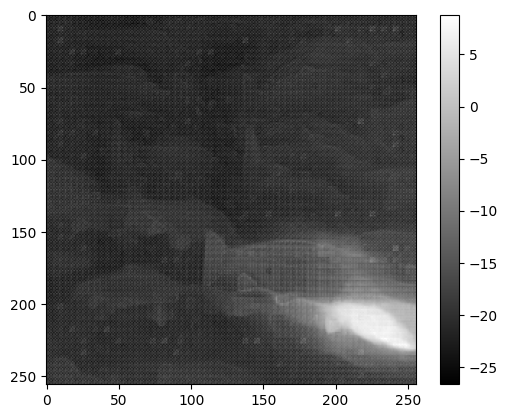

Pixel value range:
Min: -26.625
Max: 8.8125
Mean: -18.234907150268555
Pixel values:
[[     -19.75     -23.125       -19.5 ...     -21.375     -18.375         -22]
 [    -22.375       -17.5      -23.75 ...     -16.125     -21.875     -14.875]
 [    -21.375     -20.875         -21 ...       -19.5     -19.875       -21.5]
 ...
 [    -22.375     -17.125      -21.75 ...      -16.25     -19.625     -13.938]
 [     -18.75      -17.75     -17.625 ...     -15.375         -17       -17.5]
 [        -19      -17.75     -21.375 ...     -16.125      -18.75     -15.312]]


In [18]:
# Assuming logits[9][0,:,:] is your image array
image_array = logits[9][0,:,:]

# Display the image
plt.imshow(image_array, cmap='gray')  # You can use 'gray' colormap if it's grayscale
plt.colorbar()  # Optional: To show a color bar indicating the magnitude
plt.show()

# Check pixel values
print("Pixel value range:")
print(f"Min: {np.min(image_array)}")
print(f"Max: {np.max(image_array)}")
print(f"Mean: {np.mean(image_array)}")

# To print the array itself (if it's not too large)
print("Pixel values:")
print(image_array)

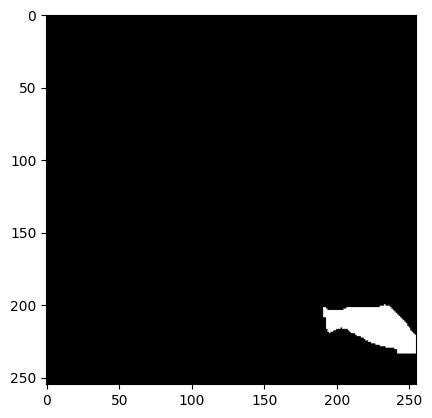

In [19]:
plt.imshow(yolo_masks[9][0,:,:], cmap='gray')

#### Using SAM2 own previous prediction as a prompt.

In [20]:
masks, scores, logits = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_boxes,
    multimask_output=False,
)

masks, scores, logits = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_boxes,
    mask_input=logits,
    multimask_output=False,
)
masks.shape # (number of masks, batches (multimask_output), H, W)

(12, 1, 1080, 1920)

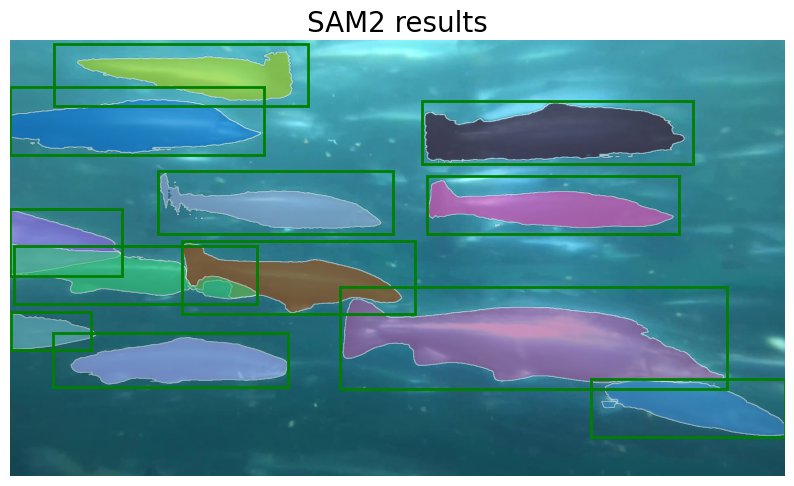

In [21]:
plt.figure(figsize=(10, 10))
plt.imshow(image_RGB)
for mask in masks:
    show_mask(mask.squeeze(0), plt.gca(), random_color=True)
for box in input_boxes:
    show_box(box, plt.gca())
plt.axis('off')
plt.title("SAM2 results", fontsize=20)
plt.show()

#### Using just YOLO segmentations as a prompt.

In [22]:
yolo_masks

array([[[[        -20,         -20,         -20, ...,         -20,         -20,         -20],
         [        -20,         -20,         -20, ...,         -20,         -20,         -20],
         [        -20,         -20,         -20, ...,         -20,         -20,         -20],
         ...,
         [        -20,         -20,         -20, ...,         -20,         -20,         -20],
         [        -20,         -20,         -20, ...,         -20,         -20,         -20],
         [        -20,         -20,         -20, ...,         -20,         -20,         -20]]],


       [[[        -20,         -20,         -20, ...,         -20,         -20,         -20],
         [        -20,         -20,         -20, ...,         -20,         -20,         -20],
         [        -20,         -20,         -20, ...,         -20,         -20,         -20],
         ...,
         [        -20,         -20,         -20, ...,         -20,         -20,         -20],
         [        -20,      

In [23]:
logits

array([[[[        -19,         -21,      -19.25, ...,      -21.25,      -18.75,     -20.375],
         [     -21.25,         -20,      -22.25, ...,      -17.75,         -21,     -15.938],
         [    -21.125,      -21.25,     -20.375, ...,     -19.875,      -20.25,       -21.5],
         ...,
         [    -21.375,     -18.625,         -21, ...,         -19,         -22,       -16.5],
         [    -19.875,     -18.875,     -19.875, ...,     -19.375,     -21.625,     -20.875],
         [        -19,       -18.5,      -21.25, ...,      -18.75,      -22.25,     -17.875]]],


       [[[    -18.125,     -21.375,       -18.5, ...,      -22.25,     -19.375,         -22],
         [        -21,     -18.625,     -22.125, ...,     -18.375,     -22.625,      -16.75],
         [    -20.625,     -21.625,      -19.75, ...,       -22.5,     -21.625,      -23.25],
         ...,
         [    -19.375,     -16.625,     -18.625, ...,       -20.5,     -23.875,      -17.75],
         [    -17.625,     -

In [24]:
input_boxes.shape

(12, 4)

In [25]:
# Original image dimensions (height, width, channels)
original_shape = results[0].orig_shape 

# list of contours
contours = get_contours(results)[0]

# Create and resize masks
yolo_masks = create_masks_from_contours_for_mask_input(original_shape, contours, target_size=(255, 255))

masks, scores, logits = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_boxes,
    mask_input=yolo_masks,
    multimask_output=False,
)

RuntimeError: The size of tensor a (64) must match the size of tensor b (63) at non-singleton dimension 3

For some reason I can't provide the predict method with a mask_input that is not a logit, even if the provided mask_input have the same type and shape as a logit.

### Example 3: Using points as prompts.

We modify the create_masks_from_contours_for_mask_input to now give 0 and 1 as a normal mask would. Then from the mask we take random points that will be used for prompting.

In [27]:
def create_simple_masks(image_shape, contours):
    # Dimensions of the mask
    height, width = image_shape[:2]
    
    # Initialize an array to hold all masks
    all_masks = np.zeros((len(contours), 1, height, width), dtype=np.uint8)
    
    for i, contour_points in enumerate(contours):
        # Convert contour points to integer type
        contour_points = contour_points.astype(np.int32)
        
        # Create a blank mask for the current contour
        mask = np.zeros((height, width), dtype=np.uint8)
        
        # Fill the contour on the mask with 1
        cv2.fillPoly(mask, [contour_points], 1)
        
        # Store the mask in the appropriate position in the all_masks array
        all_masks[i, 0, :, :] = mask
    
    return all_masks

def get_random_points_in_mask(mask, num_points):
    # Ensure the mask is a binary mask
    if mask.dtype != np.uint8:
        raise ValueError("The mask should be of dtype np.uint8")
    
    # Find the coordinates of the mask where the value is 1
    y_indices, x_indices = np.where(mask == 1)
    
    # Check if there are enough points in the mask
    if len(x_indices) < num_points:
        raise ValueError("Not enough points in the mask to sample")
    
    # Randomly sample indices
    random_indices = np.random.choice(len(x_indices), num_points, replace=False)
    
    # Get the coordinates of the sampled points
    sampled_points = np.column_stack((x_indices[random_indices], y_indices[random_indices]))
    
    return sampled_points

In [28]:
# Do a prediction with YOLO
results = yolo_segmentator.predict(image)
# Get the bboxes with YOLO
input_boxes = get_bboxes(results)[0]
# Set the SAM2 predictor to the image
predictor.set_image(image_RGB)

contours = get_contours(results)
centroids = get_centroids(contours)
points = np.array(centroids[0], dtype=np.float32)
labels = np.ones(len(points) ,dtype=np.int32)


0: 384x640 12 salmons, 302.7ms
Speed: 2.7ms preprocess, 302.7ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


In [29]:
points

array([[     747.88,      598.55],
       [     386.87,      797.93],
       [     1257.1,      724.92],
       [     152.71,      499.72],
       [     1329.2,      233.28],
       [     630.44,      405.13],
       [     1335.5,      413.71],
       [     335.76,      203.53],
       [     446.87,      87.325],
       [     1665.1,      910.31],
       [     343.18,      594.73],
       [     120.17,      717.42]], dtype=float32)

In [32]:
masks, scores, logits = predictor.predict(
    point_coords=points,
    point_labels=labels,
    box=None,
    multimask_output=False,
)

In [33]:
masks.shape

(1, 1080, 1920)

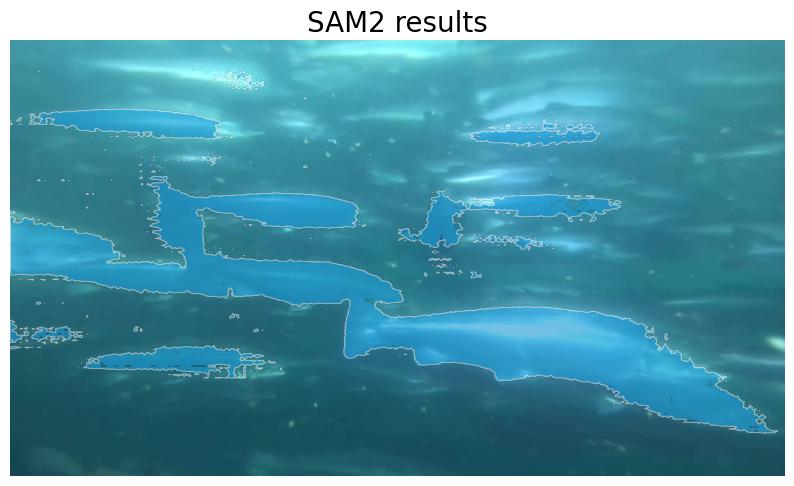

In [34]:
plt.figure(figsize=(10, 10))
plt.imshow(image_RGB)
for mask in masks:
    show_mask(mask, plt.gca(), random_color=True)
#for box in input_boxes:
#    show_box(box, plt.gca())
plt.axis('off')
plt.title("SAM2 results", fontsize=20)
plt.show()